In [1]:
import pickle
import pandas as pd
import numpy as np
import re
#import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from  sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
svd_df_daily = pd.read_csv('combined_svd_df.csv',names=['index','svd_1','svd_2','date'], index_col = 0, skiprows = 1)
svd_df_daily.set_index('date', inplace = True)
svd_df_daily.index = pd.to_datetime(svd_df_daily.index) + timedelta(days=-1)
svd_df_daily.head()

,svd_1,svd_2
date,,
2009-05-04,0.231291,0.194568
2009-05-07,0.052782,0.062221
2009-05-08,0.079785,0.035236
2009-05-11,0.098248,0.041978
2009-05-12,0.069910,0.062147


In [4]:
class FuturesClose():
    def __init__(self, path='futures_close.csv'):
        self.instrument_list = ['ES', 'NQ', 'CD', 'EC', 'JY', 'MP', 'TY', 'US', 'C', 'S', 'W', 'CL', 'GC']
        self.df = self.load(path)
        
    def load(self, path):
        df = pd.read_csv(path)
        df.set_index('date', inplace = True)
        df.index = pd.to_datetime(df.index)
        return df
    
    def features(self, inst):
        return self.momentum(inst)
    
    def price(self, inst):
        return self.df[inst]
    
    def returns(self, inst, start=1, end=2):
        returns = (self.df[inst].shift(-end) - self.df[inst].shift(-start) ) / self.df[inst].shift(-start)
        return returns
    
    def momentum(self, inst, lag=60):
        momo = pd.DataFrame(( self.df[inst] - self.df[inst].shift(lag) ) / self.df[inst])
        momo = momo.dropna()
        momo.columns += '_{}D'.format(lag)
        return momo
    

In [5]:
class VolFeatures():
    def __init__(self, path='vol.pkl'):
        self.instrument_list = ['ES', 'NQ', 'CD', 'EC', 'JY', 'MP', 'TY', 'US', 'C', 'S', 'W', 'CL', 'GC']
        self.df = self.load(path)
        self.col_dict = {inst:[key for key in self.df.columns if re.match(r"{}_+".format(inst),key) ] 
                        for inst in self.instrument_list}
        
    def features(self, inst):
        return self.df[self.col_dict[inst]]
    
    def load(self, path):
        pickle_in = open(path,"rb")
        vol_pd = pickle.load(pickle_in)
        pickle_in.close()
        return vol_pd.fillna(vol_pd.mean())
   

In [6]:
fc = FuturesClose()
fc.returns('ES').head()

date
2014-01-02   -0.002707
2014-01-03    0.005713
2014-01-06    0.000994
2014-01-07    0.000284
2014-01-08    0.002695
Name: ES, dtype: float64

In [7]:
vol = VolFeatures()
vol.features('ES').head()

,ES_1M_atm_vol,ES_1M_RR25,ES_1M_RR10,ES_1M_Fly25,ES_1M_Fly10,ES_2M_atm_vol,ES_2M_RR25,ES_2M_RR10,ES_2M_Fly25,ES_2M_Fly10,ES_2M_1M_atm_vol
Date,,,,,,,,,,,
2016-11-14,0.119889,-0.037174,-0.073479,0.003789,0.015547,0.125210,-0.046645,-0.088709,0.004540,0.017257,0.005205
2016-11-15,0.097407,-0.019810,-0.038827,0.004464,0.018210,0.116007,-0.037339,-0.070383,0.004491,0.016703,0.018506
2016-11-16,0.086325,-0.015557,-0.032338,0.003478,0.014565,0.118026,-0.039720,-0.075981,0.004275,0.016356,0.031726
2016-11-17,0.078008,-0.013282,-0.026062,0.003378,0.013855,0.114574,-0.037722,-0.072023,0.003713,0.014712,0.036573
2016-11-18,0.062015,-0.009879,-0.019785,0.002611,0.011093,0.110443,-0.037831,-0.073675,0.002989,0.013092,0.048422


In [39]:
instrument_list = ['ES', 'NQ', 'CD', 'EC', 'JY', 'MP', 'TY', 'US', 'C', 'S', 'W', 'CL', 'GC']
X_dict = {}
y_dict = {}
date_min = pd.to_datetime('2016-11-14')
date_max = pd.to_datetime('2019-09-25')
for inst in instrument_list:
    X = svd_df_daily.join(fc.features(inst)).join(vol.features(inst)).dropna()
    X = X[(X.index >= date_min) & (X.index <= date_max)]
    X_dict[inst] = X
    y_dict[inst] = fc.returns(inst)[X.index]


traintest

In [40]:
class TradeModel(): 
    
    def __init__(self, model=RandomForestClassifier, *args, **kwargs):
        self.model = model(*args, **kwargs)
        
    def fit(self, X,y):
        self.model.fit(X,y)
        
    def position(self, X, cutoff=0.55):
        #converting predictions from {0,1} to {-1,1}, short/long
        position = 2*self.model.predict(X)-1
        position[self.model.predict_proba(X).max(axis=1)<=cutoff] = 0
        return position
        
    def _strategy_returns(self, x, y):
        strat_rets = x[:-2]*y[:-2]
        strat_rets_cum = (1 + strat_rets).cumprod()
        return strat_rets, strat_rets_cum
    
    def strategy_returns(self, X, returns, cutoff=0.55):
        return self._strategy_returns(returns, self.position(X, cutoff))
    
    def sharpe(self, X, returns, cutoff=0.55):
        rets = self.strategy_returns(X, returns, cutoff)[0]
        return np.mean(rets)/np.std(rets)

           

In [130]:
instrument_list = ['ES', 'NQ', 'CD', 'EC', 'JY', 'MP', 'C', 'S', 'W', 'CL']
strat_sharpes = {}
strat_rets = {}
strat_cum_rets = {}
for inst in instrument_list:
    y = 2 * (y_dict[inst]>= 0) - 1
    X_train, X_test, y_train, y_test = train_test_split(X_dict[inst], y, test_size=0.40, shuffle=False )
    tm = TradeModel(n_estimators=1000, max_features=5, max_depth=15, criterion ='entropy')
    tm.fit(X_train, y_train)
    strat_rets[inst], strat_cum_rets[inst] = tm.strategy_returns(X_test, y_dict[inst][-len(X_test):], cutoff=0.5)
    strat_sharpes[inst] = tm.sharpe(X_test, y_dict[inst][-len(X_test):],cutoff=0.5)
    print('{} sharpe {}:'.format(inst, strat_sharpes[inst]))
    

ES sharpe 0.07309265369585216:
NQ sharpe 0.006225606768687909:
CD sharpe 0.07738967166807743:
EC sharpe -0.011905855082771847:
JY sharpe 0.0040564689334535485:
MP sharpe 0.022815618931519066:
C sharpe 0.04107068269924691:
S sharpe -0.0334751473183568:
W sharpe -0.016432280084742255:
CL sharpe 0.07241041687585621:


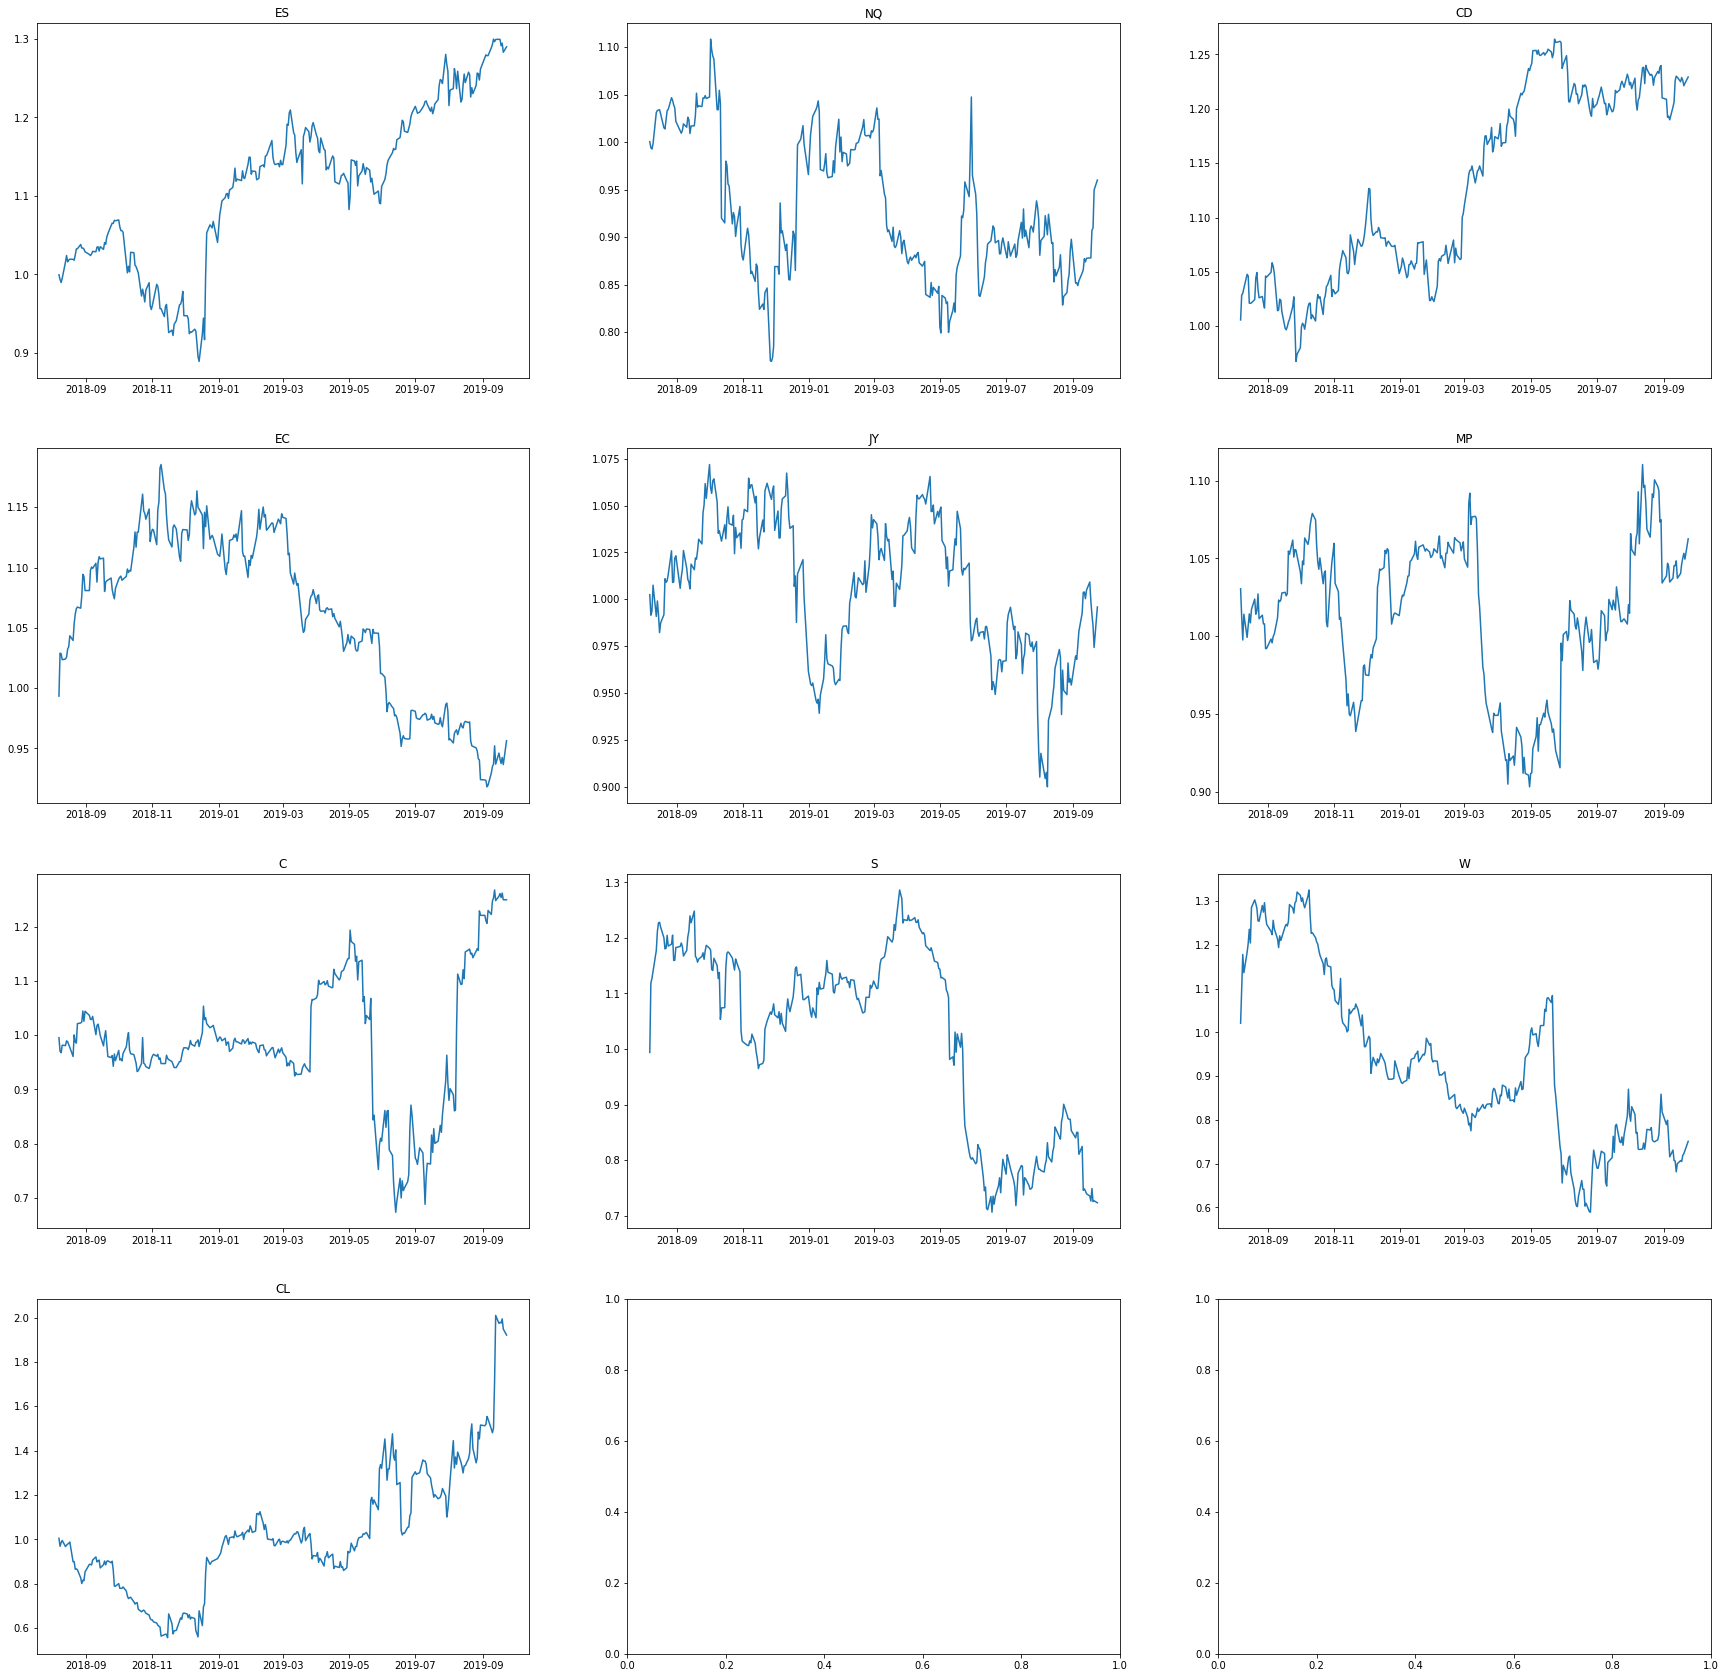

In [134]:
fig, ax = plt.subplots(4,3,figsize=(30,30))
ax = ax.ravel()
for i, inst in enumerate(instrument_list):
    ax[i].plot(strat_cum_rets[inst])
    ax[i].set_title(inst)


0.05977210826044731


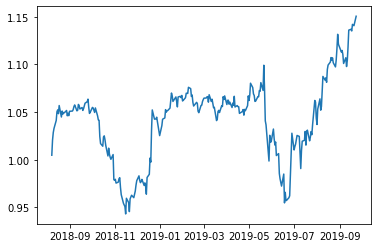

In [133]:
port_rets = pd.DataFrame(strat_rets).mean(axis=1)
plt.plot((1 + pd.DataFrame(strat_rets).mean(axis=1)).cumprod())
print(port_rets.mean()/port_rets.std())

In [128]:
strat_sharpes

{'ES': -0.03379929074561787,
 'NQ': -0.027932765444669,
 'CD': 0.036985523639566364,
 'EC': 0.03306992936272933,
 'JY': -0.07849236054104314,
 'MP': -0.03989394510370129,
 'C': 0.03097136455402637,
 'S': 0.023160664371975392,
 'W': 0.04418044397382155,
 'CL': 0.0067376143450888215}

In [44]:
tm.strategy_returns(X_test, y_dict['ES'][-len(X_test):])[1]

date
2018-04-26    1.000000
2018-04-27    1.000000
2018-04-30    1.027747
2018-05-01    1.027747
2018-05-02    1.027747
                ...   
2019-09-17    1.149651
2019-09-18    1.170863
2019-09-19    1.170863
2019-09-20    1.160413
2019-09-23    1.166664
Name: ES, Length: 355, dtype: float64

In [45]:
tm.sharpe(X_test, y_dict['ES'][-len(X_test):])

0.04252378742988993

In [46]:
tm.model.feature_importances_

array([0.09580741, 0.11283748, 0.0951219 , 0.07751538, 0.05740201,
       0.05044748, 0.05587859, 0.06217403, 0.07755241, 0.05777897,
       0.0477254 , 0.06483487, 0.07189334, 0.07303073])

In [ ]:
'''
dot_data = export_graphviz(tree, out_file=None, 
                      feature_names=X_train.columns,  
                     class_names=[str(1),str(-1)],  
                     filled=True, rounded=True,  
                    special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 
'''